# Obtaining the Dataset

In [1]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip -d train/
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!unzip -qq GTSRB_Final_Test_Images.zip -d test/ 

! rsync -a train/GTSRB/ GTSRB/
! rsync -a test/GTSRB/ GTSRB/

! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
! unzip -qq GTSRB_Final_Test_GT.zip -d GTSRB/

! rm -r train
! rm -r test
! rm *.zip

--2020-06-13 07:40:43--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  10.6MB/s    in 27s     

2020-06-13 07:41:11 (9.76 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]

--2020-06-13 07:41:22--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.8

# Importing Libraries

In [4]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

import pandas as pd
import numpy as np
from skimage import io, transform
import os

Using TensorFlow backend.


# Data Pre-Processing

In [0]:
IMG_SIZE = 48
NUM_CLASSES = 43

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.,
                             rescale = 1./255)

training_set = datagen.flow_from_directory('GTSRB/Final_Training/Images', 
                                           target_size = (IMG_SIZE, IMG_SIZE),
                                           batch_size = 32,
                                           shuffle = True)

Found 39209 images belonging to 43 classes.


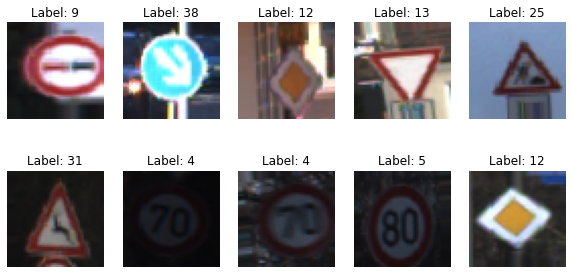

In [0]:
sample_images, sample_labels = next(training_set)
fig, axes = plt.subplots(2, 5, figsize=(10,5))
axes = axes.flatten()
for img, label, ax in zip(sample_images[:10], sample_labels[:10], axes):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Label: ' + str(label.argmax()))
plt.show()

# Model Development & Training

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)       

In [0]:
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 5
history = model.fit_generator(training_set,
                              steps_per_epoch= 39209 // batch_size, 
                              epochs=epochs,
                              callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/5
1225/1225 [==============================] - 46s 38ms/step - loss: 2.6062 - accuracy: 0.2585
Epoch 2/5
1225/1225 [==============================] - 40s 33ms/step - loss: 1.0307 - accuracy: 0.6627
Epoch 3/5
1225/1225 [==============================] - 40s 33ms/step - loss: 0.3866 - accuracy: 0.8762
Epoch 4/5
1225/1225 [==============================] - 40s 33ms/step - loss: 0.2299 - accuracy: 0.9283
Epoch 5/5
1225/1225 [==============================] - 40s 33ms/step - loss: 0.1722 - accuracy: 0.9467


# Model Evaluation

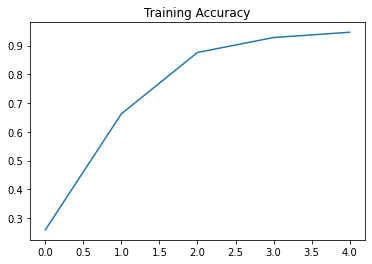

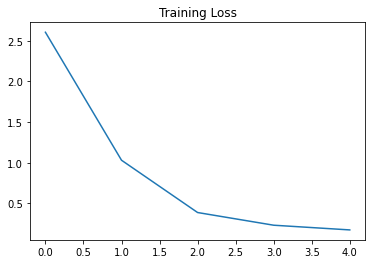

In [0]:
# Training Results 
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.show()

In [0]:
# Creating Test Dataset
IMG_SIZE = 48
labels = pd.read_csv('GTSRB/GT-final_test.csv', sep=";")
X_test = []
Y_test = []

for file_name, class_id in zip(list(labels['Filename']), list(labels['ClassId'])):
  img_path = os.path.join('GTSRB/Final_Test/Images/', file_name)
  image = io.imread(img_path)
  image = transform.resize(image, (IMG_SIZE, IMG_SIZE), preserve_range=True)
  image = image/255
  X_test.append(image)
  Y_test.append(class_id)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [0]:
# Make Predictions
Y_pred = model.predict_classes(X_test)

# Compute Test Accuracy
acc = np.sum(Y_pred == Y_test) / np.size(Y_pred)
print("Test Accuracy = {}".format(acc))

Test Accuracy = 0.9741092636579572


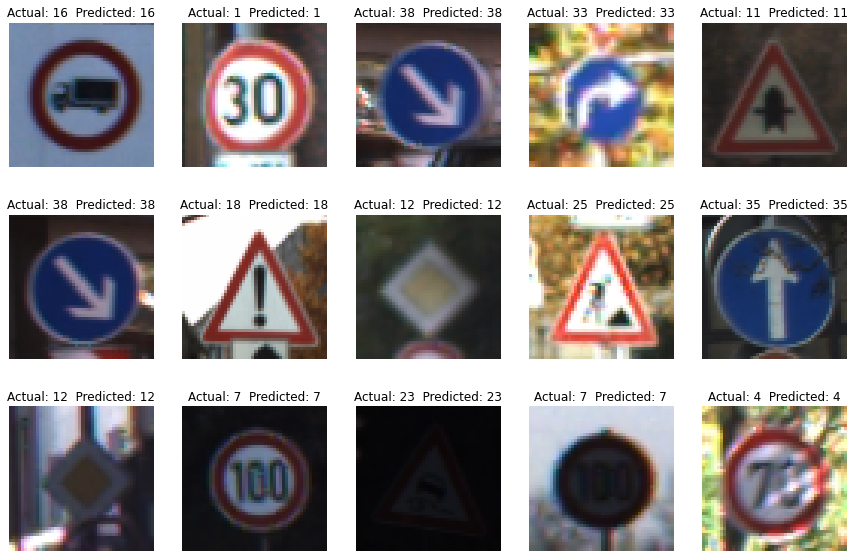

In [0]:
# Visualizing Some Results
fig, axes = plt.subplots(3, 5, figsize=(15,10))
axes = axes.flatten()
for img, actual, predicted, ax in zip(X_test[:15], Y_test[:15], Y_pred[:15], axes):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Actual: {}  Predicted: {}'.format(actual, predicted))
plt.show()